In [50]:
import sys
sys.path.insert(0,'..')

import mxnet as mx
from mxnet import nd
from mxnet import autograd
from mxnet import gluon
from mxnet import init

from mxnet.gluon import data as gluon_data
from mxnet.gluon import loss as gluon_loss
from mxnet.gluon import nn 
import mxnet.gluon.data.vision.datasets
from mxnet.gluon.data.vision.datasets import CIFAR10

import os
import pandas as pd
import numpy as np
import shutil
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
transform_train = gluon_data.vision.transforms.Compose([
    # Magnify the image to a square of 40 pixels in both height and width
    # gluon_data.vision.transforms.Resize(40),
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then shrink it to a square of 32 pixels in both height and
    # width
    # gluon_data.vision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    gluon_data.vision.transforms.RandomFlipLeftRight(),
    gluon_data.vision.transforms.ToTensor(),
    # Normalize each channel of the image
    gluon_data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

transform_test = gluon_data.vision.transforms.Compose([
    gluon_data.vision.transforms.ToTensor(),
    gluon_data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])                                  

def Load_CIFAR10():
    data_train = gluon_data.vision.CIFAR10(train=True)
    data_test = gluon_data.vision.CIFAR10(train=False)

    return data_train, data_test

def Get_Iters(train,test,batch_size,workers):
    train_iter = gluon_data.DataLoader(train.transform_first(transform_train), batch_size, shuffle = True, num_workers = workers)
    test_iter = gluon_data.DataLoader(test.transform_first(transform_test), 1, shuffle = True, num_workers = workers)

    return train_iter, test_iter

In [52]:
# Load CIFAR10 data|
train_data, test_data = Load_CIFAR10()
# Creates Data Iterators with batch_size 256 using 4 threads
train_iter, test_iter = Get_Iters(train_data,test_data,64,4)

In [53]:
class Recognizer(nn.HybridBlock):
    def __init__(self,**kwargs):
        super(Recognizer,self).__init__(**kwargs)
        self.ctx = mx.cpu() 

        self.net = nn.HybridSequential()
        with self.net.name_scope():
            self.net.add(nn.Conv2D(3,kernel_size=3,padding=1,strides=1,activation='relu'))
            self.net.add(nn.BatchNorm())
            self.net.add(nn.Conv2D(3,kernel_size=3,padding=1,strides=1,activation='relu'))
            self.net.add(nn.BatchNorm())
            self.net.add(nn.MaxPool2D())
            self.net.add(nn.Dropout(0.2))
            self.net.add(nn.Conv2D(3,kernel_size=3,padding=1,strides=1,activation='relu'))
            self.net.add(nn.BatchNorm())
            self.net.add(nn.Conv2D(3,kernel_size=3,padding=1,strides=1,activation='relu'))
            self.net.add(nn.BatchNorm())
            self.net.add(nn.MaxPool2D())
            self.net.add(nn.Conv2D(3,kernel_size=3,padding=1,strides=1,activation='relu'))
            self.net.add(nn.BatchNorm())
            self.net.add(nn.Conv2D(3,kernel_size=3,padding=1,strides=1,activation='relu'))
            self.net.add(nn.BatchNorm())
            self.net.add(nn.MaxPool2D())
            self.net.add(nn.Flatten())
            self.net.add(nn.Dense(10,activation='relu'))
            
            self.net.initialize(init.Xavier())

        self.loss_values = [] # array for training visualisation

    # Overwrite forward pass
    def forward(self, x):
        return self.net(x)

In [54]:
total_loss = 0.0
loss_function = gluon_loss.SoftmaxCrossEntropyLoss()
net = Recognizer()
trainer = gluon.Trainer(net.net.collect_params(),'sgd',{'learning_rate' : 0.1 } )
num_epochs = 100

In [ ]:
loss_values = []
for epoch in tqdm(range(1,num_epochs+1)):
    for data, label in train_iter:
        with autograd.record():
            output = net.net(data)
            loss_val = loss_function(output,label).sum()
            
        total_loss += loss_val.asscalar()
        loss_val.backward()
        trainer.step(64)
        
    loss_values.append(total_loss)

 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:32:49<41:44, 80.79s/it]

In [78]:
net.load_parameters('net.params')

10000


In [19]:
accuracy = 0
for data,label in test_iter:
    output = net.net(data)
    if output.asnumpy().argmax() == label.asnumpy()[0]:
        accuracy += 1
        
result = float(accuracy/len(test_data))
print(result*100,"%")

42.59 %


In [20]:
net.save_parameters('net1.params')

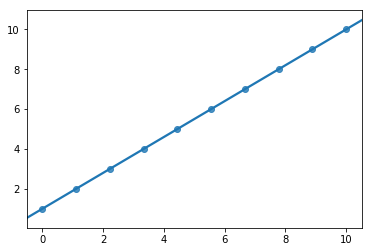

In [49]:
t = np.linspace(0,len(loss_values),len(loss_values))
sns.regplot(t,loss_values)